In [1]:
import finesse
import finesse.components as fc
import finesse.detectors as det
import finesse.analysis.actions as fa
import matplotlib.pyplot as plt
finesse.configure(plotting=True)
import numpy as np
import csv

## First let's build a simple optical setup

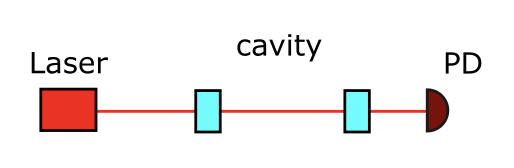

Things to try: scan the length, scan the frequency, observe the cavity resonance and free spectral range

## Now make it a bit more realistic by adding curvatures to the mirrors

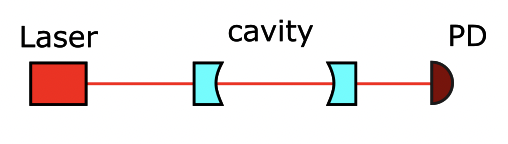

Things to try: print the cavity parameters.

## Now see how we can insert new components, and trace the Gaussian beam profile

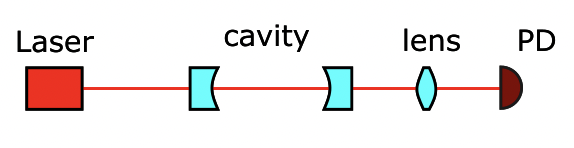

Things to try: print the Gaussian beam profile

## Insert another new component, and use it to misalign the input beam to the cavity

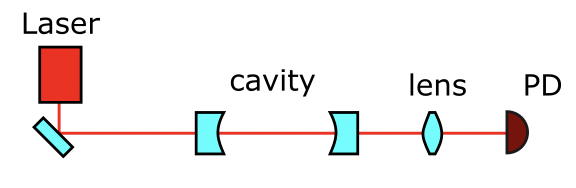

Things to try: add misalignment, scan the length or frequeuncy and observe HOM peak. Compare observed frequency separation to $\delta\nu_\mathrm{HOM}$ from cavity object.

## Now let's add and electro-optic modulator component

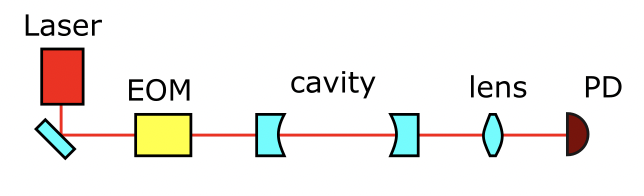

Things to try: observe sideband resonances in the cavity

## We're getting close to a Pound-Drever-Hall cavity sensing scheme. Add a "DBS" and a single demodulated PD.

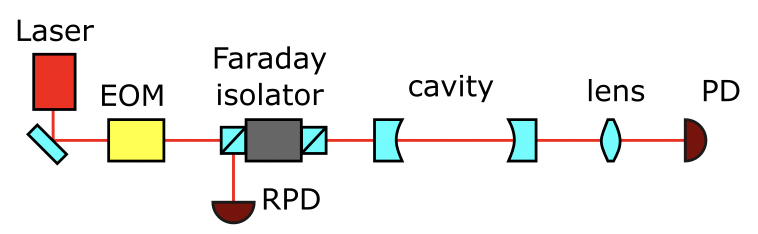

Things to try: observe the PDH error signal, I and Q phase, optimize demodulation phase for I

## Did we make it this far? Excellent! We can try a few other things if we have time:

* Do a frequency, phase or amplitude noise transfer function from laser to a PD in transmission, and/or the demodulated PD output (double demodulation).
* Add in a "pseudo-lock", feed back to laser frequency. Tune cavity length and see that laser stays resonant.
* Begin discussion of “ac control loops” and noise propagation.